In [1]:
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from pathlib import Path,PurePath
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import util
from model import *
import easydict

# import log
#
# log = log.initialise_logging("info")


In [3]:
# python train.py --cat_feat_gc --fill_zeroes --do_graph_conv --adaptive_adjacency_matrix  --random_init_adjacency_matrix --es_patience 20 --save logs/baseline_v2
args = easydict.EasyDict({
        'data': '../data/METR-LA',
        'adjdata': '../data/sensor_graph/adj_mx.pkl',
        'adjacency_type': 'doubletransition',
        'do_graph_conv': True,
        'adaptive_adjacency_matrix_only': False,
        'adaptive_adjacency_matrix': True,
        'random_init_adjacency_matrix': True,
        'seq_length': 12,
        'num_hid': 40,
        'in_dim': 2,
        'num_nodes': 207, # PEM:325 METR:207
        'batch_size': 64,
        'dropout': 0.3,
        'n_obs': None,
        'apt_size': 10,
        'cat_feat_gc': True,
        'fill_zeroes': True,
        'checkpoint': '../logs/baseline_v2/best_model.pth',
        'seed': 99,
        'dataset_name': 'METR-LA',
        'plotheatmap': True,
        'es_patience': 20
}) 

In [4]:
# set seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
# load data
# writer = SummaryWriter("run/METR-LA-2")
if torch.cuda.is_available():
    device = torch.device('cuda:0')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
else:
    device = torch.device('cpu')

In [11]:
def plot_learned_adj_matrix(model):
    adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)
    adp = adp.cpu().detach().numpy()
    adp = adp / np.max(adp)
    df = pd.DataFrame(adp[:50, :50])
    sns.set (rc = {'figure.figsize':(20, 19)})
    # sns.heatmap(df_adj, linewidths=.9, cmap='YlGnBu')
    # sns.heatmap(df, cmap="RdYlBu")
    sns.heatmap(df, linewidths=.9, cmap='YlGnBu')
    # plt.savefig("heatmap.png")

In [7]:
#def main(args, save_pred_path='preds.csv', save_metrics_path='last_test_metrics.csv', loader='test', **model_kwargs):
loader = 'test'
save_pred_path='preds.csv'
save_metrics_path='last_test_metrics.csv'
adjinit, supports = util.make_graph_inputs(args, device)
model = GWNet.from_args(args, device, supports, adjinit)
model.load_state_dict(torch.load(args.checkpoint))
model.to(device)
model.eval()
print('model loaded successfully')


model loaded successfully


In [9]:
data = util.load_dataset(args.data, args.batch_size, args.batch_size, args.batch_size, n_obs=args.n_obs, fill_zeroes=args.fill_zeroes)
scaler = data['scaler']
realy = torch.Tensor(data[f'y_{loader}']).to(device)
realy = realy.transpose(1,3)[:,0,:,:]
met_df, yhat = util.calc_tstep_metrics(model, device, data[f'{loader}_loader'], scaler, realy, args.seq_length)
df2 = util.make_pred_df(realy, yhat, scaler, args.seq_length)
met_df.to_csv(save_metrics_path)
df2.to_csv(save_pred_path, index=False)

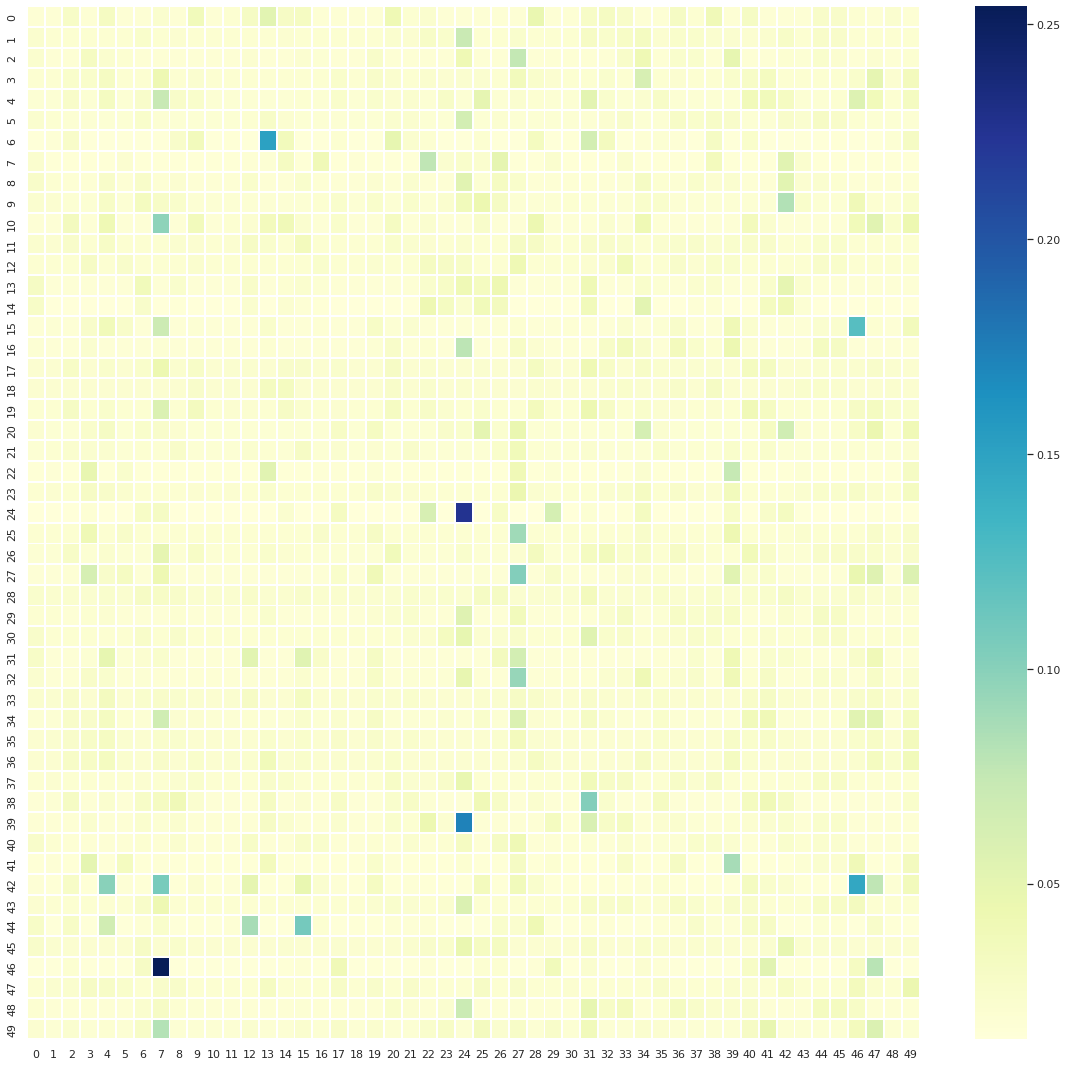

In [12]:
plot_learned_adj_matrix(model)

In [32]:
def plot_time(df, dataset_name='METR-LA',  start=0, end=12):
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.plot(df[start:end])#, label='Node ID: {}'.format())
    ax.legend()
    ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
    ax.set_ylabel('Speed')
    ax.set_xlabel('Time Intervals(1 interval=5mins) at {}')
    # ax.set_xlabel('Time Intervals(1 interval=5mins)')
    plt.show()

In [21]:
def plot_time_compare(predList, realList, dataset_name='METR-LA', start=0, end=12, node_id=0):
  df_pred = pd.DataFrame(predList)
  df_real = pd.DataFrame(realList)
  fig, ax = plt.subplots(figsize=(30, 10))
  ax.plot(df_pred[node_id][start:end], label='Pred horizon ID: {}'.format(1))
  ax.plot(df_real[node_id][start:end], label='Real Node ID: {}'.format(1))
  ax.legend()
  ax.set_title('Speeds Recorded for Nodes ({})'.format(dataset_name))
  ax.set_ylabel('Speed')
  ax.set_xlabel('Time Intervals(1 interval=5mins)')
  plt.show()

In [27]:
df2 = pd.read_csv('preds.csv')

In [28]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1417950 entries, 0 to 1417949
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   y_last     1417950 non-null  float64
 1   yhat_last  1417950 non-null  float64
 2   y_3        1417950 non-null  float64
 3   yhat_3     1417950 non-null  float64
dtypes: float64(4)
memory usage: 43.3 MB


In [11]:
pred_horizon = df2.y_last.to_list()
real_horizon = df2.yhat_last.to_list()

In [29]:
df_last =  df2[['y_last', 'yhat_last']]

In [15]:
#  24hrs=288*1, 48hrs=288*2, 72hrs=288*3
start = 0
end = 288*3  #108
horizon = 11
node_id = 5

No handles with labels found to put in legend.


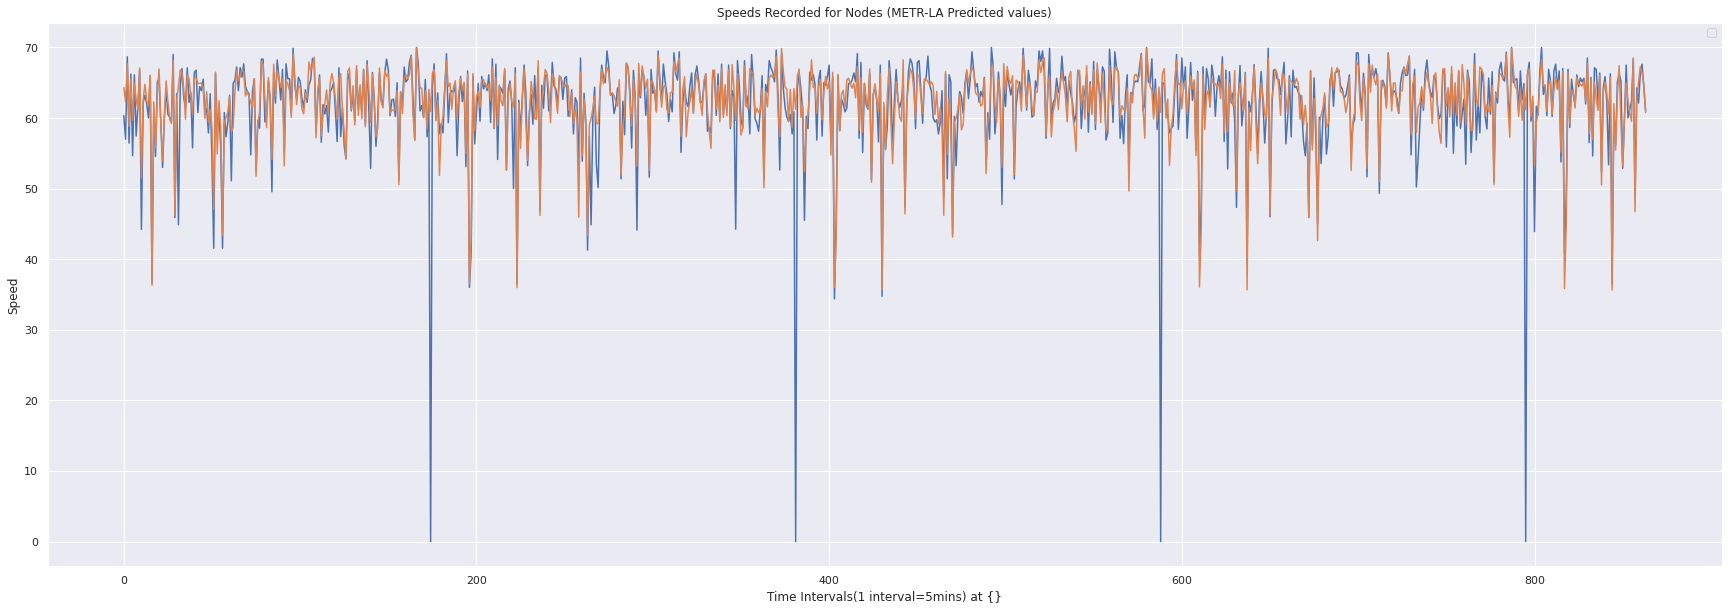

No handles with labels found to put in legend.


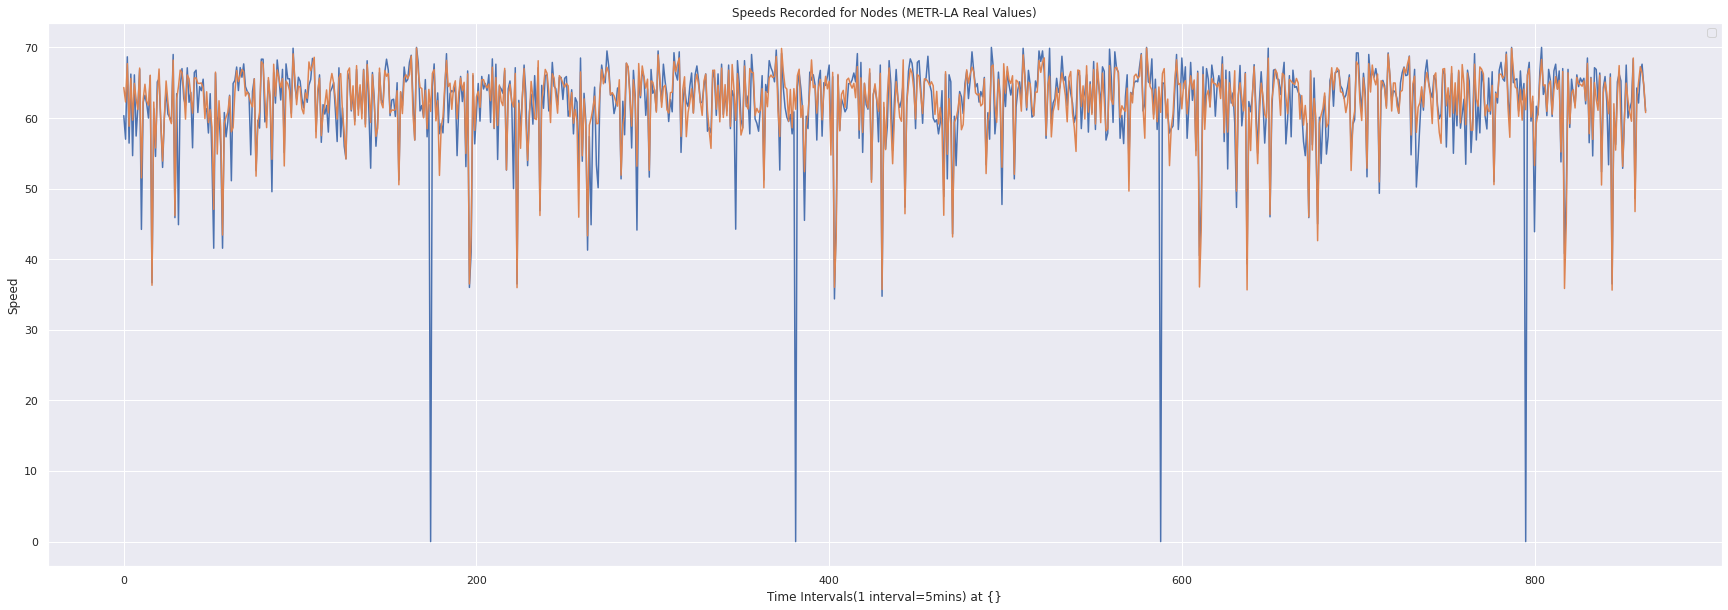

In [33]:
plot_time(df=df_last, dataset_name='METR-LA Predicted values', start=start, end=end) 
plot_time(df=df_last, dataset_name='METR-LA Real Values', start=start, end=end)


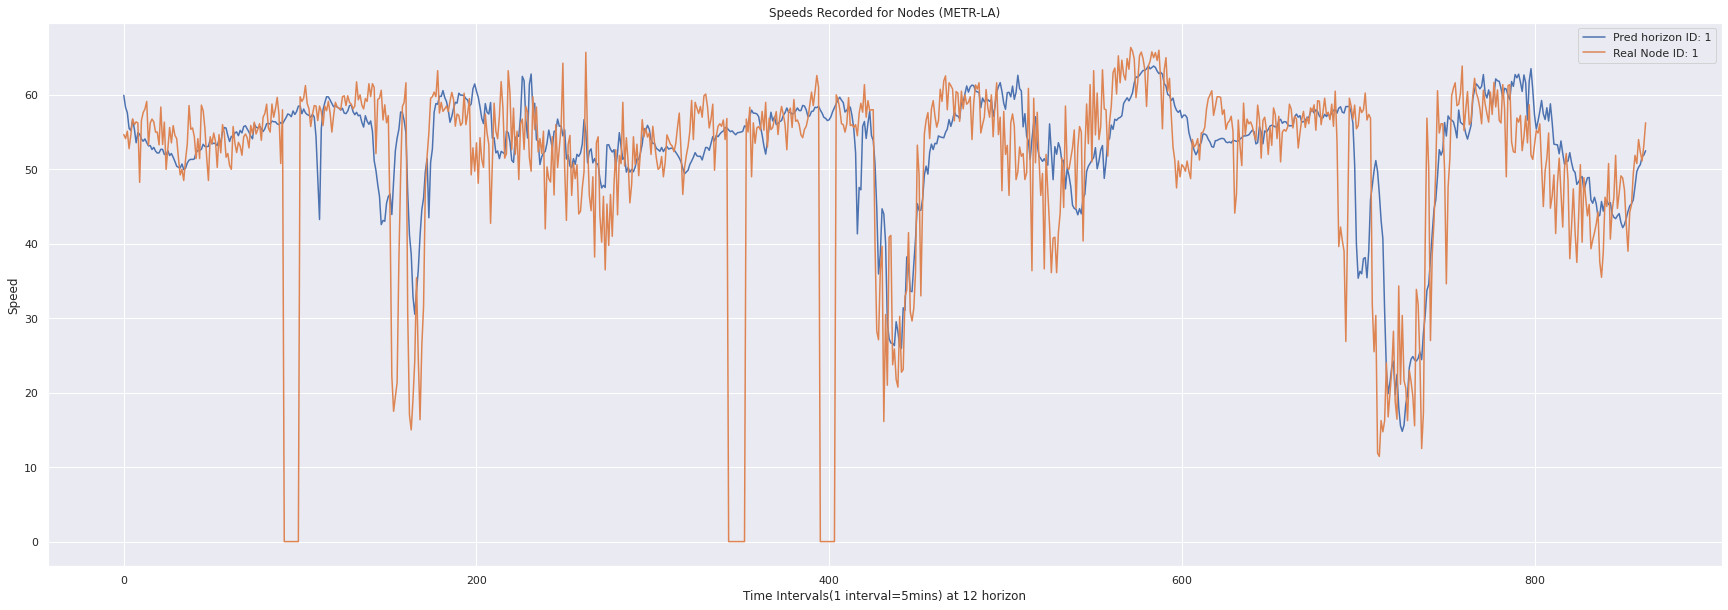

In [32]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=node_id, horizon=horizon)

### Fig 3. Prediction data vs Test data for Node 1 (72hr period)
- The Model is able to predict the correct values. However, it cannot account for when there is no traffic being recorded at the node

In [33]:
print('The standard deviation values for the Predicted nodes are\n', df_pred.std()[:5])
print('The standard deviation values for the Predicted nodes are\n', df_real.std()[:5])

The standard deviation values for the Predicted nodes are
 0    12.130571
1     1.466655
2     9.958584
3     8.132169
4    13.863317
dtype: float32
The standard deviation values for the Predicted nodes are
 0    22.086756
1    19.356901
2    21.309414
3    18.040911
4    21.634510
dtype: float32


In [34]:
print('The mean values for the Predicted nodes are\n', df_pred.mean()[:5])
print('The mean values for the Predicted nodes are\n', df_real.mean()[:5])

The mean values for the Predicted nodes are
 0    61.470375
1    64.757812
2    64.825211
3    52.775734
4    48.910629
dtype: float32
The mean values for the Predicted nodes are
 0    54.779102
1    58.223618
2    58.480721
3    47.261707
4    41.741451
dtype: float32


In [58]:
adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)

In [59]:
device = torch.device('cpu')
adp.to(device)
adp = adp.cpu().detach().numpy()

In [68]:
adp = adp*(1/np.max(adp))
adp_tempt = adp[:50, :50]
df_adj = pd.DataFrame(adp_tempt)

In [69]:
df_adj.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.103899,0.077847,0.071709,0.075651,0.071709,0.093941,0.125425,0.074245,0.074576,0.071709,...,0.071709,0.154310,0.071709,0.129379,0.084995,0.089197,0.071709,0.072102,0.071709,0.076903
1,0.064293,0.064293,0.093414,0.064293,0.113011,0.064293,0.093821,0.067211,0.140761,0.154999,...,0.153662,0.064293,0.064293,0.064293,0.064293,0.087466,0.064432,0.064293,0.143590,0.104212
2,0.058582,0.070338,0.073234,0.080163,0.058068,0.163934,0.150412,0.058068,0.058068,0.058068,...,0.058068,0.064803,0.066222,0.065131,0.071835,0.058068,0.058068,0.065346,0.114186,0.058068
3,0.081162,0.068243,0.067127,0.067127,0.070097,0.067127,0.085639,0.069289,0.067127,0.067127,...,0.067127,0.067127,0.067127,0.087779,0.109746,0.100710,0.067127,0.099639,0.067127,0.090688
4,0.088832,0.066087,0.063002,0.063002,0.063002,0.064370,0.122235,0.063962,0.063002,0.063002,...,0.063002,0.063002,0.063002,0.123586,0.083958,0.101512,0.063002,0.068958,0.063002,0.096463


<AxesSubplot:>

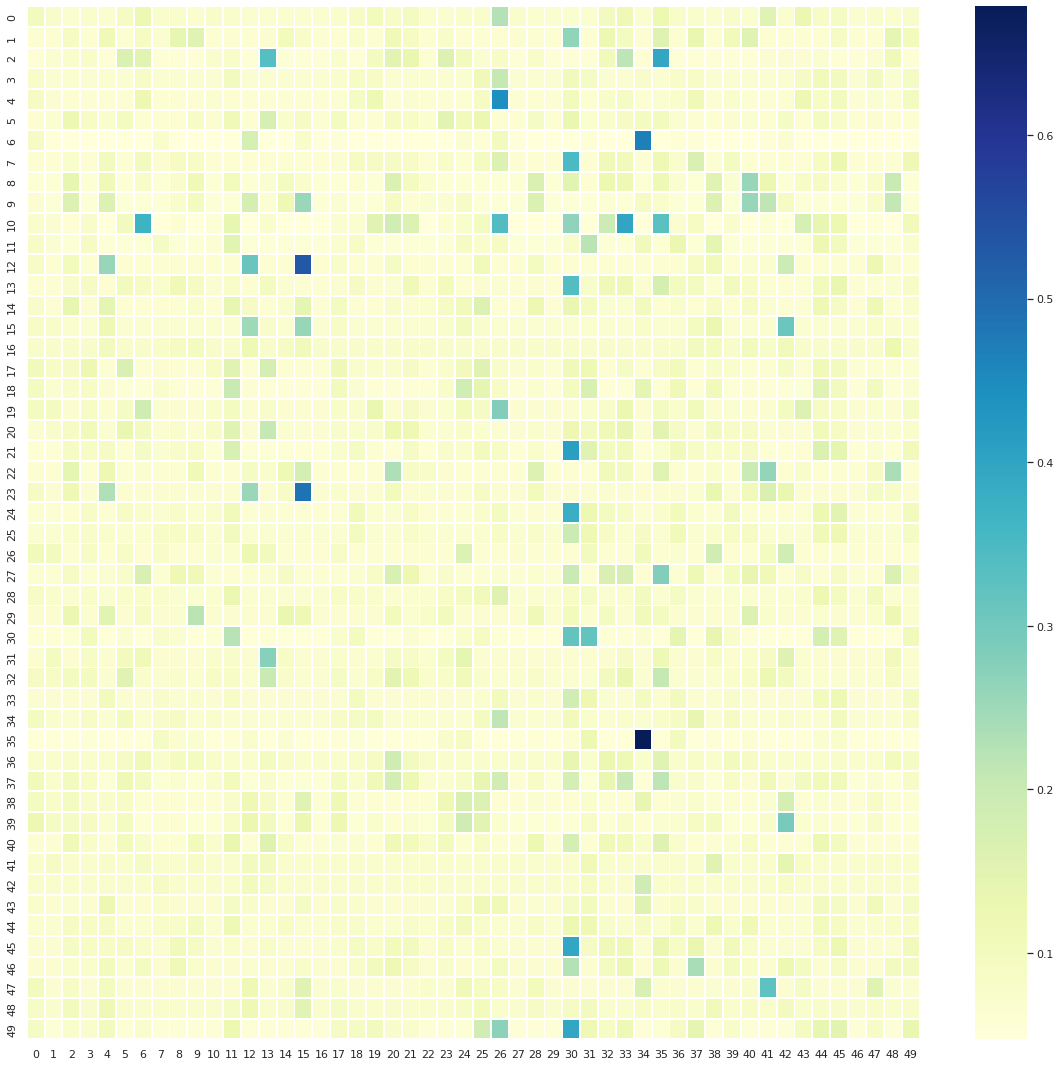

In [70]:
sns.set (rc = {'figure.figsize':(20, 19)})
sns.heatmap(df_adj, linewidths=.9, cmap='YlGnBu')
# plt.savefig("./emb"+ '.pdf')


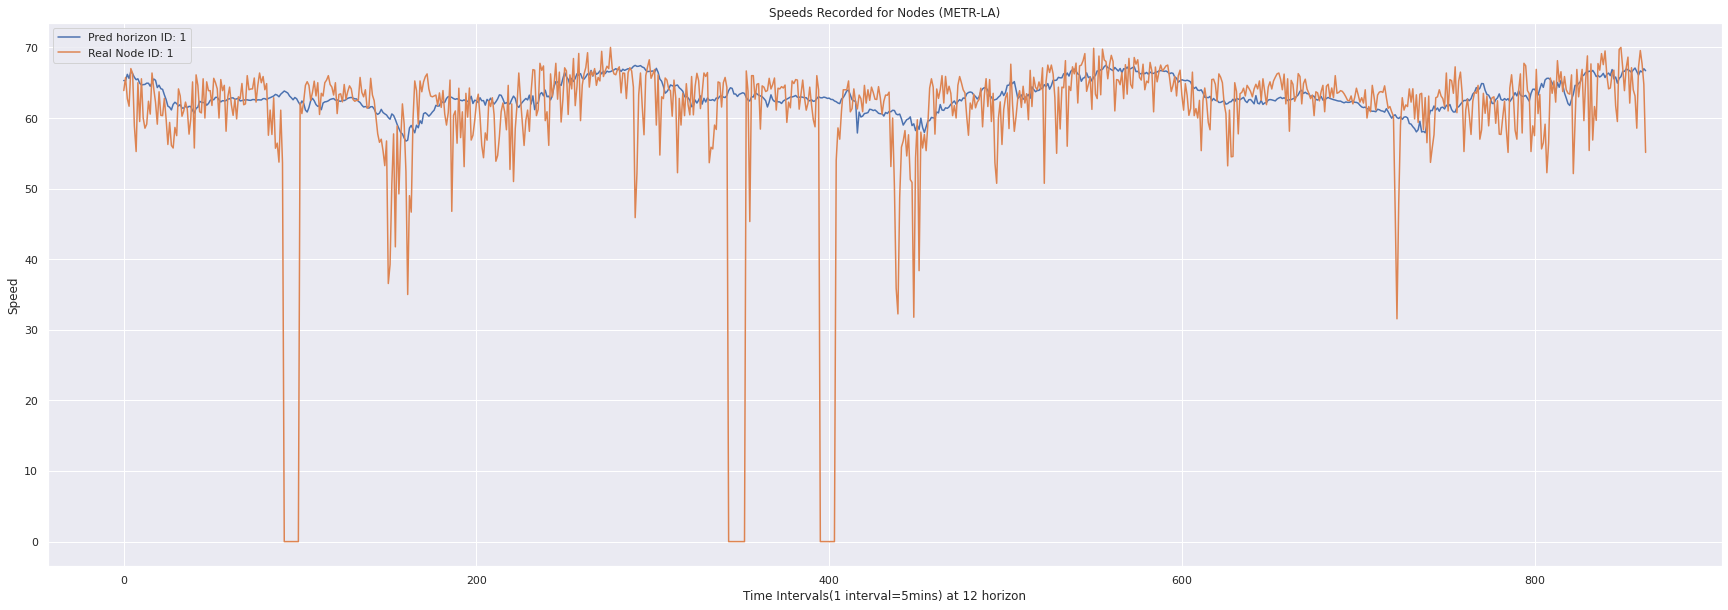

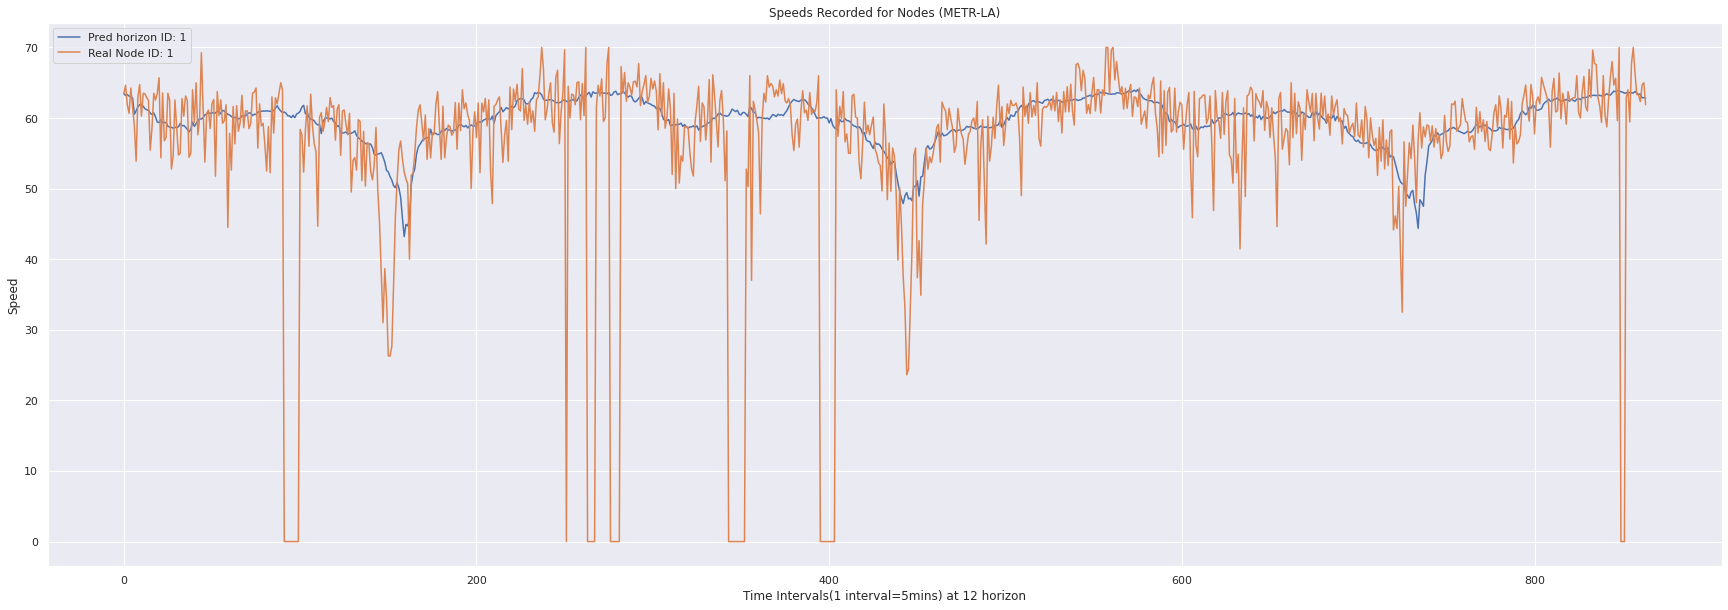

In [67]:
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=65, horizon=horizon)
plot_time_compare(predList=predList, realList=realList, start=start, end=end, node_id=30, horizon=horizon)

## Fig 4 Real and Pred plots for node 65 and 30 as seen in the heatmap
- Node 65 influences node 30 as seen in the similar dips in their graphs.


In [29]:
def printPrincipalDiagonal(mat, n):
    values = []
    for i in range(n):
        for j in range(n):
 
            # Condition for principal diagonal
            if (i == j):
                values.append(mat[i][j])
    return values


In [34]:
values = printPrincipalDiagonal(adp, 207)

In [45]:
data = str(Path(sys.path[0] + '/data/sensor_graph'))
df_met = pd.read_csv(data + '/graph_sensor_locations.csv')

In [87]:
df_met['magnitude'] = values
df_met['magnitude'] = (df_met['magnitude']/ df_met['magnitude'].max()) 

In [88]:
df_met.to_csv(data+'/test_metrla.csv', index=False)

In [89]:
df_met['magnitude'].max()

1.0

In [90]:
df_met['magnitude'].min()

0.16255197830672016

In [91]:
df_met['magnitude'].median()

0.24290553340714577

In [85]:
df_met.head(50)

,index,sensor_id,latitude,longitude,magnitude
0,0,773869,34.15497,-118.31829,23.344682
1,1,767541,34.11621,-118.23799,21.988673
2,2,767542,34.11641,-118.23819,33.861742
3,3,717447,34.07248,-118.26772,23.951456
4,4,717446,34.07142,-118.26572,30.926379
5,5,717445,34.06913,-118.25932,21.346582
6,6,773062,34.05368,-118.23369,16.255198
7,7,767620,34.13486,-118.22932,20.257564
8,8,737529,34.20264,-118.47352,26.682137
9,9,717816,34.15562,-118.46860,21.231682


In [3]:






# if args.plotheatmap == "True":
#     adp = F.softmax(F.relu(torch.mm(model.nodevec1, model.nodevec2)), dim=1)
#     device = torch.device('cpu')
#     adp.to(device)
#     adp = adp.cpu().detach().numpy()
#     adp = adp*(1/np.max(adp))
#     adp = adp[:50, :50]
#     df = pd.DataFrame(adp)
#     sns.heatmap(df, linewidths=.5, cmap='YlGnBu')
#     plt.savefig("./emb"+ '.pdf')



In [92]:
y12 = realy[:,99,11].cpu().detach().numpy()
yhat12 = scaler.inverse_transform(yhat[:,99,11]).cpu().detach().numpy()

y3 = realy[:,99,2].cpu().detach().numpy()
yhat3 = scaler.inverse_transform(yhat[:,99,2]).cpu().detach().numpy()

df2 = pd.DataFrame({'real12':y12,'pred12':yhat12, 'real3': y3, 'pred3':yhat3})
df2.to_csv('./wave.csv',index=False)